# Free Induction Decay - A Real Use Case

The following will give an example of a complex pulse using many of the features discussed in the previous tutorial examles: We will use two channels, parameters and parameter constraints, parameterized measurements and atomic and non-atomic pulse templates. This is based on real experiments. To see another, a bit more artificial example for a pulse setup use case that offers more verbose explanations, see [Gate Configuration - A Full Use Case](03GateConfigurationExample.ipynb).

We start by creating some atomic pulse templates using `PointPT` which will be the building blocks for the more complex pulse structure we have in mind.

In [1]:
from qupulse.pulses import PointPT, SequencePT, ForLoopPT, RepetitionPT, MappingPT
import qupulse.pulses.plotting
import numpy as np
import sympy as sp
from sympy import sympify as S

channel_names = ['RFX', 'RFY']

S_init = PointPT([(0,        'S_init'),
                  ('t_init', 'S_init')],
                 channel_names=channel_names, identifier='S_init')

meas_wait = PointPT([(0,             'meas'),
                     ('t_meas_wait', 'meas')],
                   channel_names=channel_names)

adprep = PointPT([(0,           'meas'),
                  ('t_ST_prep', 'ST_plus - ST_jump/2', 'linear'),
                  ('t_ST_prep', 'ST_plus + ST_jump/2'),
                  ('t_op',      'op', 'linear')],
                 parameter_constraints=['Abs(ST_plus - ST_jump/2 - meas) <= Abs(ST_plus - meas)',
                                        'Abs(ST_plus - ST_jump/2 - meas)/t_ST_prep <= max_ramp_speed',
                                        'Abs(ST_plus + ST_jump/2 - op)/Abs(t_ST_prep-t_op) <= max_ramp_speed'],
                 channel_names=channel_names, identifier='adprep')

adread = PointPT([(0,           'op'),
                  ('t_ST_read', 'ST_plus + ST_jump/2', 'linear'),
                  ('t_ST_read', 'ST_plus - ST_jump/2'),
                  ('t_meas_start',      'meas', 'linear'),
                  ('t_meas_start + t_meas_duration', 'meas')],
                 parameter_constraints=['Abs(ST_plus - ST_jump/2 - meas) <= Abs(ST_plus - meas)',
                                        'Abs(ST_plus - ST_jump/2 - meas)/t_ST_read <= max_ramp_speed',
                                        'Abs(ST_plus + ST_jump/2 - op)/Abs(t_ST_read-t_op) <= max_ramp_speed'],
                 channel_names=channel_names, identifier='adread',
                 measurements=[('m', 't_meas_start', 't_meas_duration')])

free_induction = PointPT([(0, 'op-eps_J'),
                          ('t_fid', 'op-eps_J')], channel_names=channel_names)

In the next step, we combine our building blocks into more complex pulses step by step.
We first define our core functionality pulse template `stepped_free_induction`.
The pulse template `pulse` surrounds our functionality with pulses to reset/initialize our qubit and allow for data acquisition.
We will use `pulse` in a `ForLoopPT` `looped_pulse` to perform a parameter sweep. Our final pulse template `experiment` repeats  this whole thing a number of times to allow for statistical aggregating of measurement data and represents the complete pulse template for our experiment.

In [2]:


stepped_free_induction = MappingPT(free_induction, parameter_mapping={'t_fid': 't_start + i_fid*t_step'}, allow_partial_parameter_mapping=True)

pulse = SequencePT(S_init, meas_wait, adprep, stepped_free_induction, adread)

looped_pulse = ForLoopPT(pulse, loop_index='i_fid', loop_range='N_fid_steps')

experiment = RepetitionPT(looped_pulse, 'N_repetitions', identifier='free_induction_decay')

In [3]:
print(experiment.parameter_names)

{'max_ramp_speed', 't_meas_start', 'ST_jump', 't_ST_read', 'eps_J', 't_init', 'ST_plus', 'N_repetitions', 't_step', 't_start', 'op', 't_meas_duration', 'S_init', 't_meas_wait', 'N_fid_steps', 't_op', 'meas', 't_ST_prep'}


Let's use some reasonable (but low) values for our parameters and plot our `experiment` pulse (we set the number of repeititions of `looped_pulse` only to 2 so that the plot does not get too stuffed).

Note that we provide numpy arrays of length 2 for some parameters to assign different values for different channels (see also [The PointPulseTemplate](00PointPulse.ipynb)).

<IPython.core.display.Javascript object>


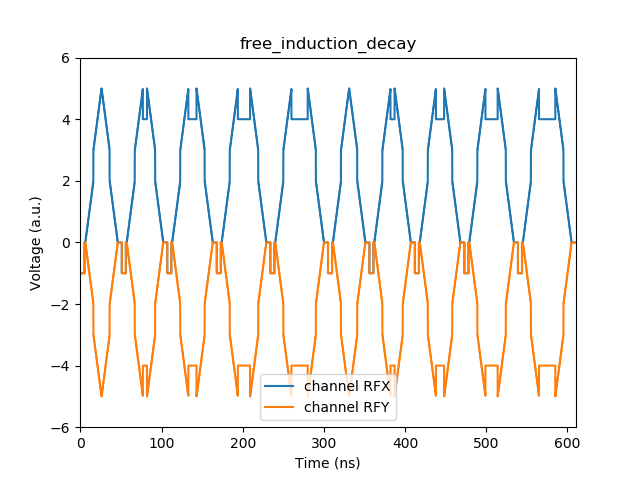

In [4]:
%matplotlib notebook

example_values = dict(meas=[0, 0],
                      op=[5, -5],
                      eps_J=[1, -1],
                      ST_plus=[2.5, -2.5],
                      S_init=[-1, -1],
                      ST_jump=[1, -1],
                      max_ramp_speed=0.3,
                      
                      t_init=5,
                      
                      t_meas_wait = 1,
                      
                      t_ST_prep = 10,
                      t_op = 20,
                      
                      t_ST_read = 10,
                      t_meas_start = 20,
                      t_meas_duration=5,
                     
                      t_start=0,
                      t_step=5,
                      N_fid_steps=5, N_repetitions=2)

from qupulse.pulses.plotting import plot

_ = plot(experiment, example_values)

We can clearly make out the many repetitions of our basic functionality pulse and also the varying duration between the voltage peaks due to our parameter sweep (as well as the two-fold repetition of the sweep itself).

Let's also quickly plot only a single repetition by setting according parameters for our `experiment` pulse template.

<IPython.core.display.Javascript object>


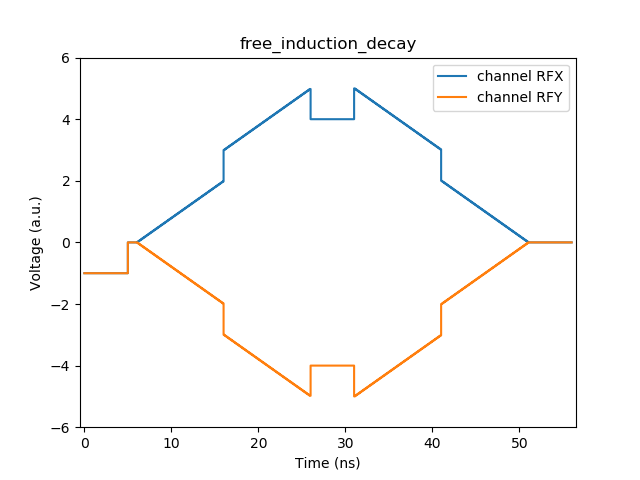

In [5]:
example_values['N_fid_steps'] = 1
example_values['N_repetitions'] = 1
example_values['t_start'] = 5

_ = plot(experiment, example_values)

As a last step we will save the pulse and some example parameters so we can use it in other examples.

In [6]:
import json
from qupulse.serialization import FilesystemBackend, PulseStorage

pulse_storage = PulseStorage(FilesystemBackend('./serialized_pulses'))

# overwrite all pulses explicitly
pulse_storage.overwrite('adprep', adprep)
pulse_storage.overwrite('S_init', S_init)
pulse_storage.overwrite('adread', adread)
pulse_storage.overwrite('free_induction_decay', experiment)

with open('parameters/free_induction_decay.json', 'w') as parameter_file:
    json.dump(example_values, parameter_file)

print('Successfully saved pulse and example parameters')

Successfully saved pulse and example parameters
